In [1]:
from sena.data.norec.dataloader import load_binary_dataset
import sena.utils.preprocessing as preprocessing
import pandas as pd

In [2]:
# Loading data
data = load_binary_dataset()

train = data["train"]
val = data["dev"]
test = data["test"]

# Shuffling data
train = train.sample(frac=1).reset_index(drop=True)
val = val.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

# Cleaning values in the text column
train = preprocessing.clean_text(train, "text")
val = preprocessing.clean_text(val, "text")
test = preprocessing.clean_text(test, "text")

# Combining data for later use
combined_data = pd.concat([train, val, test]).reset_index(drop=True)

In [3]:
from collections import Counter
import math

num_words = Counter()
for review in combined_data["text"]:
    for word in review.split(" "):
        num_words[word] += 1

# Deciding the vocabulary size
num_words = len(num_words) / 20
num_words = math.ceil(num_words / 1000) * 1000
print("Number of words:", num_words)

Number of words: 26000


In [4]:
from keras.preprocessing.text import Tokenizer

# Separating texts and labels
X_train, y_train = train["text"], train["label"]
X_val, y_val = val["text"], val["label"]
X_test, y_test = test["text"], test["label"]

# Fitting a tokenizer to text from the combined data
tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(combined_data["text"].tolist())

# Converting texts to sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

In [5]:
from keras_preprocessing.sequence import pad_sequences
import numpy as np

# Deciding embedding vector length
maxlen = (int(np.ceil(np.mean([len(text.split()) for text in combined_data.text]))))

# Padding sequences with zeros until they reach a certain length
X_train = pad_sequences(X_train, maxlen=maxlen, padding="post", truncating="post")
X_val = pad_sequences(X_val, maxlen=maxlen, padding="post", truncating="post")
X_test = pad_sequences(X_test, maxlen=maxlen, padding="post", truncating="post")

In [6]:
from keras.utils.np_utils import to_categorical

num_classes = len(np.unique(y_train))
print("Number of classes:", num_classes)

# One-hot encoding of labels
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

Number of classes: 2


In [7]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape, end="\n\n")
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape, end="\n\n")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (34903, 204)
y_train shape: (34903, 2)

X_val shape: (4360, 204)
y_val shape: (4360, 2)

X_test shape: (4351, 204)
y_test shape: (4351, 2)


In [8]:
import itertools

# 10 most common words in the vocabulary
dict(itertools.islice(tokenizer.word_index.items(), 10))

{'<OOV>': 1,
 'litt': 2,
 'får': 3,
 'gjør': 4,
 'helt': 5,
 'godt': 6,
 'filmen': 7,
 'år': 8,
 'alt': 9,
 'nok': 10}

In [9]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout

model = Sequential()
model.add(Embedding(num_words, 100, input_length=maxlen, trainable=True))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

In [10]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 204, 100)          2600000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 2,684,738
Trainable params: 2,684,738
Non-trainable params: 0
_________________________________________________________________


In [11]:
from keras.callbacks import EarlyStopping

callbacks = [EarlyStopping(monitor="val_accuracy", patience=3)]

epochs = 20
batch_size = 32
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1,
                    callbacks=callbacks)

Epoch 1/20
1091/1091 [==============================] - 183s 165ms/step - loss: 0.4605 - accuracy: 0.7937 - val_loss: 0.3922 - val_accuracy: 0.8319
Epoch 2/20
1091/1091 [==============================] - 181s 166ms/step - loss: 0.2842 - accuracy: 0.8845 - val_loss: 0.3959 - val_accuracy: 0.8390
Epoch 3/20
1091/1091 [==============================] - 186s 171ms/step - loss: 0.1424 - accuracy: 0.9447 - val_loss: 0.5184 - val_accuracy: 0.8351
Epoch 4/20
1091/1091 [==============================] - 187s 171ms/step - loss: 0.0498 - accuracy: 0.9832 - val_loss: 0.8215 - val_accuracy: 0.8300
Epoch 5/20
1091/1091 [==============================] - 187s 171ms/step - loss: 0.0263 - accuracy: 0.9905 - val_loss: 0.9304 - val_accuracy: 0.8294


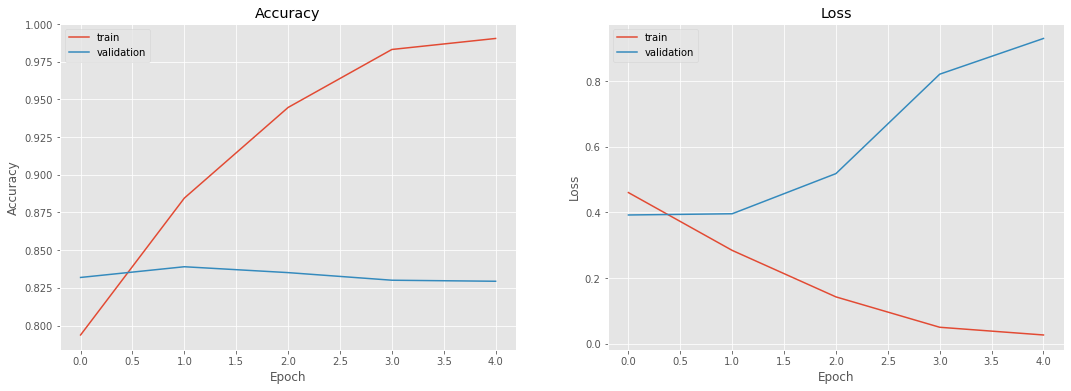

In [12]:
from sena.utils.visualization import plot_history

plot_history(history)

In [13]:
val_loss, val_acc = model.evaluate(X_test, y_test, verbose=1)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

136/136 [==============================] - 6s 47ms/step - loss: 0.9570 - accuracy: 0.8242
Validation loss: 0.9569666981697083
Validation accuracy: 0.8241783380508423


In [14]:
from datetime import datetime

if val_acc > 0.8:
    print("Saving model...")
    model.save(f"models/SA-LSTM-BINARY-{val_acc}-{datetime.now().strftime('%Y%m%d')}.h5")